In [1]:
import os
import json
import logging
import numpy as np
from utils.load_dataset import load_dataset

with open("./config.json") as f:
    config = json.load(f)

logger = logging.getLogger("")
dataset_name = 'cifar100'
arch = 'resnet18'
num_augs = 2

dataset = load_dataset(
    dataset=dataset_name,
    train_batch_size=128,
    test_batch_size=128,
    val_split=0.0,
    augment=False,
    shuffle=False,
    root_path=config['data_dir'],
    random_seed=0,
    mean=[0, 0, 0],
    std=[1, 1, 1],
    logger=logger,
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [2]:
def get_scores_and_masks(seeds, dataset, method, num_augs, eps=None):
    h = 0.001
    num_seeds = len(seeds)

    if eps:
        aug_scores_file_name = {
            'curv_zo' : "curvature_scores_zo_{}_resnet18_eps_{}_seed_{}_{}_tid{}.pt",
            'curv' : "curvature_scores_{}_{}_{}_tid{}.pt",
            'prob' : "prob_{}_resnet18_eps_{}_seed_{}_{}_tid{}.pt",
            'loss' : "losses_{}_{}_{}_tid{}.pt",
            'mentr' : "m_entropy_{}_{}_{}_tid{}.pt",
            'loss_g' : "loss_g_{}_{}_{}_tid{}.pt",
        }    
    else:
        aug_scores_file_name = {
            'curv_zo' : "curvature_scores_zo_{}_{}_{}_{}_tid{}.pt",
            'curv' : "curvature_scores_{}_{}_{}_{}_tid{}.pt",
            'prob' : "prob_{}_{}_{}_tid{}.pt",
            'loss' : "losses_{}_{}_{}_tid{}.pt",
            'mentr' : "m_entropy_{}_{}_{}_tid{}.pt",
            'loss_g' : "loss_g_{}_{}_{}_tid{}.pt",
        }

    score_seeds_v_seed = np.zeros((num_augs, dataset.train_length, num_seeds))
    mask_seeds_v_seed = np.zeros((dataset.train_length, num_seeds))
    start_seed = seeds[0]
    for exp_idx in seeds:
        array_idx = exp_idx - start_seed
        augs = 1 if method == 'mentr' else num_augs
        for aug_idx in range(augs):
            if eps:
                file_name = aug_scores_file_name[method].format(dataset.name, eps, exp_idx, h, aug_idx)
                absolute_file_name = os.path.join(
                    config['precomputed_scores_dir'], 
                    f'{dataset.name}_dp', 
                    file_name)
                scores = np.load(absolute_file_name)['data']
            else:
                if 'curv' in aug_scores_file_name[method]:
                    file_name = aug_scores_file_name[method].format(dataset.name, arch, exp_idx, h, aug_idx)
                else:
                    file_name = aug_scores_file_name[method].format(dataset.name, arch, exp_idx, aug_idx)
                absolute_file_name = os.path.join(
                    config['precomputed_scores_dir'], 
                    dataset.name,
                    file_name)
                scores = np.load(absolute_file_name)['data']

            score_seeds_v_seed[aug_idx, :, array_idx] = scores

        if dataset == 'imagenet':
            array = np.load(f'/path/imagenet-resnet50/{0.7}/{exp_idx}/aux_arrays.npz')
            mask_idxs = array['subsample_idx']
            mask_seeds_v_seed[mask_idxs, array_idx] = 1
        else:
            mask_idxs = np.load(os.path.join(config['subset_idxs_dir'], f"{exp_idx}.npy"))
            mask_seeds_v_seed[mask_idxs, array_idx] = 1

    return score_seeds_v_seed, mask_seeds_v_seed

def get_score_dist_params(scores, masks, num_augs):
    means_in = []
    means_out = []
    var_in = []
    var_out = []
    for aug in range(num_augs):
        in_scores = np.where(masks == 1, scores[aug], np.NaN)
        out_scores = np.where(masks == 0, scores[aug], np.NaN)
        means_in.append(np.nanmean(in_scores, axis=1))
        means_out.append(np.nanmean(out_scores, axis=1))
        var_in.append(np.nanvar(in_scores, axis=1))
        var_out.append(np.nanvar(out_scores, axis=1))

    return {
        'means_in': np.row_stack(means_in),
        'means_out': np.row_stack(means_out),
        'var_in': np.row_stack(var_in),
        'var_out': np.row_stack(var_out)
    }


In [3]:
scores = {}
masks = {}
dist_params = {}
train_end_seed = 64
train_seeds = list(range(train_end_seed))
test_seeds = [0]
eps = 1e-22

In [4]:
def log_err(x):
    return np.log(x + eps)

def logit_scale(x):
    x = x / (1 - x + eps)
    return log_err(x)

def nll(curv_score, mean, var):
    ll = - ( ( (curv_score - mean)**2) / (2 * (var ** 2) ) ) -0.5 * np.log(var ** 2) - 0.5 * np.log(2 * np.pi)
    return -ll

def likelihood(curv_score, mean, var):
    nll = - ( ( (curv_score - mean)**2) / (2 * (var ** 2) ) ) - 0.5 * np.log(var ** 2) - 0.5 * np.log(2 * np.pi)
    likelihood_val = np.exp(nll)
    return likelihood_val

def get_likelihood_ratio(test_scores, dist_params, num_augs, train_scores, train_masks):
    in_likelihood = np.zeros((test_scores.shape[1]))
    out_likelihood = np.zeros_like(in_likelihood)
    for aug in range(num_augs):
        test_score_aug = test_scores[aug, :, 0]
        in_likelihood += likelihood(
            test_score_aug, 
            dist_params['means_in'][aug], 
            dist_params['var_in'][aug] + eps)

        out_likelihood += likelihood(
            test_score_aug, 
            dist_params['means_out'][aug], 
            dist_params['var_out'][aug] + eps)

    likelihood_ratio = in_likelihood / (out_likelihood + eps)
    return likelihood_ratio

def get_likelihood_ratio_cnst(test_scores, dist_params, num_augs, train_scores, train_masks):
    in_likelihood = np.zeros((test_scores.shape[1]))
    out_likelihood = np.zeros_like(in_likelihood)
    for aug in range(num_augs):
        test_score_aug = test_scores[aug, :, 0]
        in_likelihood += likelihood(
            test_score_aug, 
            dist_params['means_in'][aug], 
            1)

        out_likelihood += likelihood(
            test_score_aug, 
            dist_params['means_out'][aug], 
            1)

    likelihood_ratio = in_likelihood / (out_likelihood + eps)
    return likelihood_ratio

def get_nll_ratio(test_scores, dist_params, num_augs, train_scores, train_masks):
    in_likelihood = np.zeros((test_scores.shape[1]))
    out_likelihood = np.zeros_like(in_likelihood)
    for aug in range(num_augs):
        test_score_aug = test_scores[aug, :, 0]
        in_likelihood += nll(
            test_score_aug, 
            dist_params['means_in'][aug], 
            dist_params['var_in'][aug] + 1e-32)

        out_likelihood += nll(
            test_score_aug, 
            dist_params['means_out'][aug], 
            dist_params['var_in'][aug] + 1e-32)

    likelihood_ratio = in_likelihood - out_likelihood
    return -likelihood_ratio

def get_nll_ratio_c(test_scores, dist_params, num_augs, train_scores, train_masks):
    in_likelihood = np.zeros((test_scores.shape[1]))
    out_likelihood = np.zeros_like(in_likelihood)
    for aug in range(num_augs):
        test_score_aug = test_scores[aug, :, 0]
        in_likelihood += nll(
            test_score_aug, 
            dist_params['means_in'][aug], 
            0.5)

        out_likelihood += nll(
            test_score_aug, 
            dist_params['means_out'][aug], 
            0.5)

    likelihood_ratio = in_likelihood - out_likelihood
    return -likelihood_ratio

def get_identity(test_scores, dist_params, num_augs, train_scores, train_masks):
    return test_scores[0]

def get_mast(test_scores, dist_params, num_augs, train_scores, train_masks):
    aug = 0
    threshold = (dist_params['means_in'][aug] +  dist_params['means_out'][aug]) / 2 
    return -(test_scores[aug, :, 0] - threshold)

def get_mast_offline(test_scores, dist_params, num_augs, train_scores, train_masks):
    aug = 0
    threshold = dist_params['means_in'][aug]
    return -(test_scores[aug, :, 0] - threshold)

def get_ye_et_el_attack_r(test_scores, dist_params, num_augs, train_scores, train_masks):
    aug = 0
    alpha = 1e-4
    out_scores = np.where(train_masks == 0, train_scores[aug], np.NaN)
    threshold = np.nanpercentile(out_scores, alpha * 100, axis=1)
    return -(test_scores[aug, :, 0] - threshold)

def get_class_based(test_scores, dist_params, num_augs, train_scores, train_masks):
    # This is handled during roc calculations
    return -test_scores[0, :, 0]

def get_loss_count(test_scores, dist_params, num_augs, train_scores, train_masks):
    in_scores = np.where(train_masks == 1, train_scores[0], np.NaN)
    threshold = np.nanmean(in_scores)
    pred = (test_scores[:, :, 0] < threshold).sum(0) / num_augs
    return pred

methods = [
    ('curv_zo', log_err, get_likelihood_ratio, 'Curv ZO LR', num_augs, train_seeds), 
]

In [5]:
for info_type, score_func, _, method_name, augs, seeds in methods:
    if method_name in scores:
        continue
    
    score, mask = get_scores_and_masks(
        seeds=seeds, 
        dataset=dataset,
        method=info_type,
        num_augs=augs)

    score = score_func(score)
    params = get_score_dist_params(score, mask, augs)
    scores[method_name] = score
    masks[method_name] = mask
    dist_params[method_name] = params


In [6]:

test_scores = {}
test_masks = {}
epsilons = [1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0]
for eps in epsilons:
    for info_type, score_func, _, method_name, augs, _ in methods:
        test_score, test_mask = get_scores_and_masks(
            seeds=test_seeds, 
            dataset=dataset,
            method=info_type,
            num_augs=augs,
            eps=eps)

        score_for_seed = score_func(test_score)
        mask_for_seed = test_mask
        if method_name in test_scores:
            test_scores[method_name] = np.concatenate([test_scores[method_name], score_for_seed], axis=2)
            test_masks[method_name] = np.concatenate([test_masks[method_name], mask_for_seed], axis=1)
        else:
            test_scores[method_name] = score_for_seed
            test_masks[method_name] = mask_for_seed



In [7]:
from sklearn.metrics import roc_auc_score, roc_curve, balanced_accuracy_score

aucs = {}
accs = {}
for e_idx, eps in enumerate(epsilons):
    for idx, (info_type, _, pred_func, method_name, augs, _) in enumerate(methods):
        y_pred = pred_func(
            test_scores[method_name][:, :, e_idx, np.newaxis],
            dist_params[method_name],
            augs,
            scores[method_name],
            masks[method_name])

        y_true = test_masks[method_name][:, e_idx, np.newaxis]
        
        fpr, tpr, thr = roc_curve(y_true, -y_pred, pos_label=1)
        auc = roc_auc_score(y_true, -y_pred)

        # Find the optimal threshold: where the sum of FPR and TPR is closest to 1
        # "Balanced accuracy is symmetric. That is, the metric
        # assigns equal cost to false-positives and to false-negatives."
        # - LiRA https://arxiv.org/pdf/2112.03570.pdf
        optimal_idx = np.argmin(np.abs(fpr + tpr - 1))
        optimal_threshold = thr[optimal_idx]

        # Binarize predictions based on the optimal threshold
        y_pred_binarized = (y_pred >= optimal_threshold).astype(int)

        # Calculate Balanced Accuracy
        balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binarized)

        if method_name in accs:
            accs[method_name] += [balanced_accuracy]
            aucs[method_name] += [auc]
        else:
            accs[method_name] = [balanced_accuracy]
            aucs[method_name] = [auc]
        


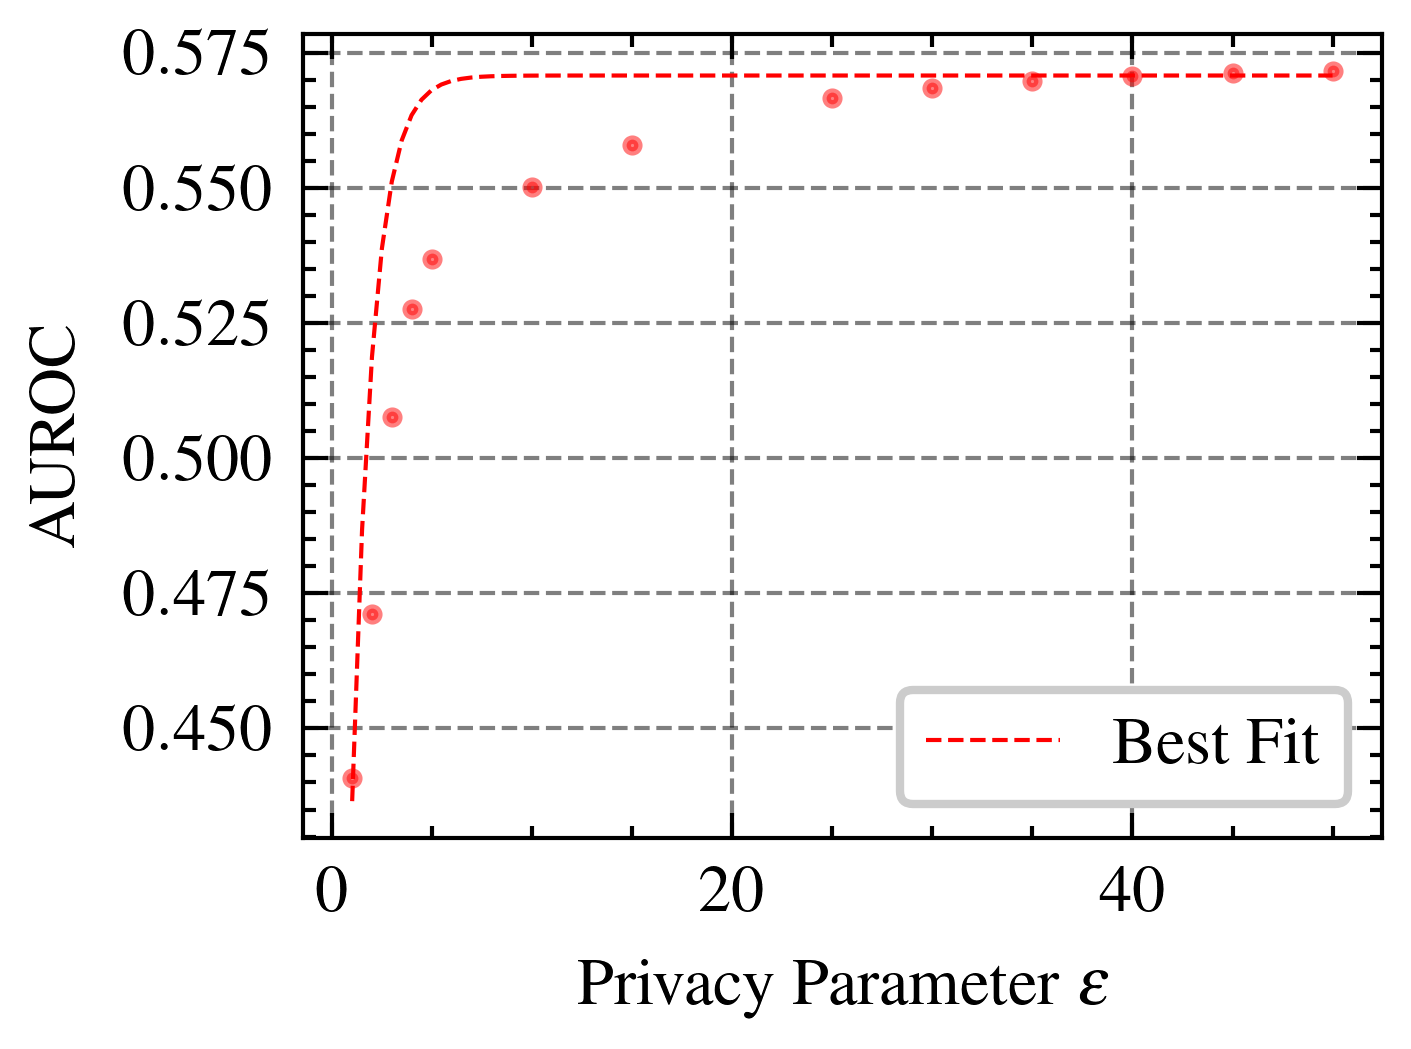

In [8]:
import matplotlib.pyplot as plt
import scienceplots
from scipy.optimize import curve_fit
plt.style.use(['ieee', 'science', 'grid'])

textwidth = 3.31314
aspect_ratio = 6/8
scale = 0.7
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))

def model(x, l, m, c, s):
    return s * (l * m * (1 - np.exp(-x )) + l + c) **2

colors = plt.cm.tab10(np.linspace(0, 1, 10))

colors = ['red', 'green', 'blue', 'orange']
for c_idx, (key, val) in enumerate(accs.items()):
    popt, _ = curve_fit(model, epsilons, aucs[key])#
    l = popt[0]
    m = popt[1]
    c = popt[2]
    s = popt[3]
    epsilons_fine = np.linspace(1.0, 50, 100)

    # The theorem predicts and upper bound so add offset
    fitted_vals = model(epsilons_fine, l, m, c, s) + 0.015

    # Plot the original data points
    plt.scatter(epsilons, aucs[key], color=colors[c_idx], alpha=0.5, s=2)
    
    # Plot the fitted curve
    # The theorem predicts and upper bound so 
    plt.plot(epsilons_fine, fitted_vals, label='Best Fit', color=colors[c_idx], lw=0.5, ls='dashed')
    

plt.xlabel('Privacy Parameter $\epsilon$')
plt.ylabel('AUROC')
plt.legend()
plt.savefig("./plots/eps_vs_acc.png")
plt.savefig("./plots/eps_vs_acc.svg")
plt.show()
